In [16]:
!pip install git+https://github.com/millawell/bias-ml-dh.git#subdirectory=material/notebooks/bias_ml_dh_utils
!pip install --upgrade tqdm

  Cloning https://github.com/millawell/bias-ml-dh.git to /private/var/folders/rz/nyzm_31n3d7f8mqgwyh_gtpr0000gp/T/pip-req-build-aumtg5a7
  Running command git clone -q https://github.com/millawell/bias-ml-dh.git /private/var/folders/rz/nyzm_31n3d7f8mqgwyh_gtpr0000gp/T/pip-req-build-aumtg5a7
  Created wheel for bias-ml-dh-utils: filename=bias_ml_dh_utils-0.1-py3-none-any.whl size=2211 sha256=383c788a0a020f716ed1571d3db7b1606b4af73fc2dd9361038e4685ebd9a60d
  Stored in directory: /private/var/folders/rz/nyzm_31n3d7f8mqgwyh_gtpr0000gp/T/pip-ephem-wheel-cache-ezhue1pz/wheels/d4/8d/af/a27ef01a2dc2a7313cfcbb128b906b77e986b55a6ebd3d52a7
Successfully built bias-ml-dh-utils
Requirement already up-to-date: tqdm in /usr/local/lib/python3.7/site-packages (4.43.0)


In [17]:
import pandas as pd
import spacy
import numpy as np
import torch as tr
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from collections import Counter
from spacy.tokenizer import Tokenizer

from bisect import bisect_left
from tqdm.notebook import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import bias_ml_dh_utils as utils

nlp = spacy.load("en_core_web_sm")

In [18]:
#set paths and decide for data and pretrained word embeddings
path_glove = './'

data = 'yelp' #yelp, amazon, imdb, wikipedia
pretrained_embeddings = 'glove' #aggressive, non-aggressive, all, glove

In [19]:
def load_data(data='yelp'):
    #loads data and feeds it into a data frame
    
    
    if data in("yelp","amazon","imdb"):

        filepath_dict = {'yelp': './data/yelp_labelled.txt' ,
                         'amazon': './data/amazon_cells_labelled.txt',
                         'imdb': './data/imdb_labelled.txt'}

        df_list = []

        df = pd.read_csv(filepath_dict[data], names=['sentence', 'label'], sep='\t')

        sentences = df['sentence'].values
        y = df['label'].values

        df['spacified'] = list(nlp.pipe(df['sentence']))
        df['lemmatized'] = df.spacified.apply(lambda doc: [t.lemma_ for t in doc])
        cnts = Counter(l for doc in df.lemmatized for l in doc)
        vocab = sorted([el[0] for el in cnts.items() if el[1] >= 10])
        vocab.insert(0," ")

        max_it = 40
        
    elif data=="wikipedia":
        
        aggression_annotated_comments = pd.read_csv("data/aggression_annotated_comments.tsv", sep="\t")
        agression_annotation = pd.read_csv("data/agression_annotation.tsv", sep="\t")

        agression_data = pd.merge(aggression_annotated_comments, agression_annotation, on="rev_id")

        sentences = []
        labels = []
        for rev_id, rev in tqdm(agression_data.groupby("rev_id")):
            sentences.append(rev.iloc[0].comment)
            labels.append(rev.aggression.sum()/len(rev) >.5)

        with open("data/vocab.txt") as fin:
            vocab,_ = zip(*map(lambda x: x.split(" "), fin))
            vocab = sorted(list(vocab) + ["<unk>"])  

        max_it = 100
        y = np.array(labels)
        
    else:
        raise ValueError('data not known')
        
    return vocab, sentences, y, max_it

In [20]:
def set_embedding_path(pretrained_embeddings='glove'):
    #sets path to load embeddings later
    
    if pretrained_embeddings=='glove':

        embedding_dim = 50
        embedding_path = '{}/glove.6B/glove.6B.{}d.txt'.format(path_glove, embedding_dim)

    elif pretrained_embeddings=='all':
        
        embedding_dim = 32
        embedding_path = "data/all_comments_vec.txt"
        
    elif pretrained_embeddings=='aggressive':
        
        embedding_dim = 32
        embedding_path = "data/aggressive_comments_vec.txt"
        
    elif pretrained_embeddings=='non-aggressive':
        
        embedding_dim = 32
        embedding_path = "data/non_aggressive_comments_vec.txt"
        
    return embedding_dim, embedding_path

def get_max_row(word_seq):
    #returns the longest row to decide on padding

    max_row = 0
    for irow, row in enumerate(word_seq):
        if len(row) > max_row:
            max_row = len(row)
            
    return max_row

In [21]:
def prepare_data(data):
    #loads data, extracts relevant data, pads data, train/validation/test split

    vocab, sentences, y, max_it = load_data(data)
    word_seq = utils.tokenize_data(sentences, vocab)
    y = y[:word_seq.shape[0]]

    max_row = get_max_row(word_seq)

    input_data = utils.data_padding(word_seq, np.min([max_row, 500]))
    
    x_train,x_test,y_train,y_test = train_test_split(
                                                    input_data.numpy(), y,  
                                                    test_size=0.2)

    x_val,x_test,y_val,y_test = train_test_split(
                                                    x_test, y_test,  
                                                    test_size=0.5)
    
    return x_train, x_val, x_test, y_train, y_val, y_test, vocab, max_it

In [22]:
def train_classifier(net, x_train, y_train, x_val, y_val, max_it=100):
    
    #sets optimizer and loss function
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    criterion = nn.BCEWithLogitsLoss()


    loss_hist = []
    loss_val_hist = []

    for it in range(max_it):

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(tr.from_numpy(x_train))
        loss = criterion(outputs, tr.from_numpy(y_train[:,np.newaxis]).float())
        loss.backward()
        optimizer.step()

        loss_hist.append(loss.detach())

        if it%10==0 or it==(max_it-1):
            print("training loss: ", loss_hist[-1])

            outputs_val = net.forward(tr.from_numpy(x_val))
            loss_val_hist.append(criterion(outputs_val, tr.from_numpy(y_val[:,np.newaxis]).float()).detach())

            print("validation loss: ",loss_val_hist[-1])
            
    y_predict = (outputs_val.detach().numpy()>=0).astype(int).ravel()
    print(classification_report(y_val, y_predict))

    plt.plot(loss_hist)
    plt.plot(np.arange(0,max_it+1,10),loss_val_hist)
    plt.legend(['training_loss', 'validation_loss'])
    plt.savefig('loss.png', dpi=300)
    
    outputs_val = net.forward(tr.from_numpy(x_test))
    y_predict = (outputs_val.detach().numpy()>=0).astype(int).ravel()
    print(classification_report(y_test, y_predict))
            
    return loss_hist, loss_val_hist, outputs_val

In [23]:
def predict_label(input_data, label_names = ['negative','positive']):
    #applies trained model to input_data and predicts the corresponding label
    word_seq = utils.tokenize_data(input_data, vocab)
    X = utils.data_padding(word_seq)
    net.eval()
    output = net.forward(X)
    label = tr.clamp(tr.sign(output.detach()),0,1)
    
    print("The predicted label is: ",label_names[int(label)])
    
    return output.detach()

In [24]:
#prepares train and test data
x_train, x_val, x_test, y_train, y_val, y_test, vocab, max_it = prepare_data(data)

embedding_dim, embedding_path = set_embedding_path(pretrained_embeddings)
embedding_matrix = utils.create_embedding_matrix(
    embedding_path,
    vocab,  
    embedding_dim)

1000it [00:00, 4083.25it/s]
400000it [00:06, 57488.53it/s]


In [25]:
 ## OWN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  
        filter_sizes = [1,2,3,5]
        num_filters = 36
        
        #Embedding layer
        self.embedding_layer = nn.Embedding(embedding_matrix.shape[0], embedding_dim)
        self.embedding_layer.weight = nn.Parameter(tr.from_numpy(embedding_matrix).float())
        self.embedding_layer.weight.requires_grad = False
        
        #Convolution layer
        self.convolution_layer = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embedding_dim)) for K in filter_sizes])
        Ks = [nn.Conv2d(1, num_filters, (K, embedding_dim)) for K in filter_sizes]
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(len(Ks)*num_filters, 1)
        
    def forward(self,x):
        x = self.embedding_layer(x)
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convolution_layer] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = tr.cat(x, 1)
        x = self.dropout(x)
        logit = self.linear(x)
        return(logit)
    
net = Net()

training loss:  tensor(0.6926)
validation loss:  tensor(0.6695)
training loss:  tensor(0.5340)
validation loss:  tensor(0.6614)
training loss:  tensor(0.4226)
validation loss:  tensor(0.6223)
training loss:  tensor(0.3160)
validation loss:  tensor(0.5876)
training loss:  tensor(0.2243)
validation loss:  tensor(0.5594)
              precision    recall  f1-score   support

           0       0.62      0.64      0.63        45
           1       0.70      0.67      0.69        55

    accuracy                           0.66       100
   macro avg       0.66      0.66      0.66       100
weighted avg       0.66      0.66      0.66       100

              precision    recall  f1-score   support

           0       0.85      0.76      0.80        54
           1       0.75      0.85      0.80        46

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100



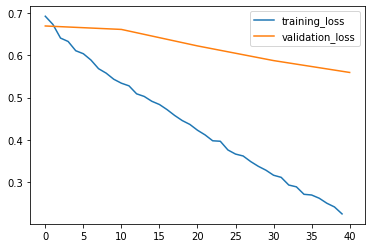

In [26]:
_ = train_classifier(net, x_train, y_train, x_val, y_val, max_it)

In [27]:
#Try out new data!
data = ['this movie was really good']
output = predict_label(data)
print(output)

1it [00:00, 84.97it/s]

The predicted label is:  positive
tensor([[2.8226]])
